# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')

pd.set_option('max_columns', 999)
pd.set_option('max_rows', 250)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
def load_data(ignore_clean_cache=False):
    """
    Loads data from either source csv or from cleaned cache. Six (6) files
    are expected
        * data/arvato_data/Udacity_AZDIAS_052018.csv
        * data/arvato_data/Udacity_CUSTOMERS_052018.csv
        * data/arvato_data/Udacity_MAILOUT_052018_TEST.csv
        * data/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv
        
        * data/DIAS Attributes - Values 2017.xlsx
        * data/DIAS Information Levels - Attributes 2017.xlsx
        
    Arguments:
        ignore_clean_cache: reloads raw data, even if clean cache exists
    
    Returns:
        azdias, customer, mailout_test, mailout_train, attributes, information
    """
    def only_named_columns(col):
        """
        Removes columns from DataFrame while loaded that are unnamed
        """
        return 'Unnamed' not in col
    
    # Attributes and Information
    
    attributes = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1, usecols=only_named_columns)
    attributes[['Attribute', 'Description']] = attributes[['Attribute', 'Description']].ffill()
    
    information = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=only_named_columns)
    
    print('loading azdias data...')
    azdias = pd.read_csv('data/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', usecols=only_named_columns)
    print('loading customers data...')
    customers = pd.read_csv('data/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', usecols=only_named_columns)
    print('loading mailout test data')
    mailout_test = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', usecols=only_named_columns)
    print('loading mailout training data')
    mailout_train = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', usecols=only_named_columns)
    
    print('Returning data in this order: azdias, customers, mailout_test, mailout_train, attributes, information')

    return azdias, customers, mailout_test, mailout_train, attributes, information

In [4]:
azdias, customers, mailout_test, mailout_train, attributes, information = load_data()

loading azdias data...


/home/patrick/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


loading customers data...
loading mailout test data
loading mailout training data
Returning data in this order: azdias, customers, mailout_test, mailout_train, attributes, information


An error about mixed types for cols 18 and 19 ws returned during the loading process. We'll address that later

## Examining AZDIAS and Customer Data

First, and examination of the columns that are present in both of these datasets

In [5]:
azdias_cols = azdias.columns
customers_cols = customers.columns

In [6]:
print(f'Number of columns in AZDIAS: {len(azdias_cols)}')
print(f'Number of columns in Customers: {len(customers_cols)}')

Number of columns in AZDIAS: 366
Number of columns in Customers: 369


In [7]:
extra_customer_cols = list(set(customers_cols) - set(azdias_cols))
extra_azdias_cols = list(set(azdias_cols) - set(customers_cols))

There are only three extra columns in the Customers data which do not appear in the AZDIAS data. Also, we don't have any extra columns to deal with in the AZDIAS data. This is consistent with what was described above.

In [8]:
print(f'Columns found in Customers but not in AZDIAS: {extra_customer_cols}')
print(f'Columns found in AZDIAS but not in Customers: {extra_azdias_cols}')

Columns found in Customers but not in AZDIAS: ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']
Columns found in AZDIAS but not in Customers: []


A closer look at the extra columns in the Cusotmer dataset shows two categorical columns (PRODUCT_GROUP and CUSTOMER_GROUP) and one binary indicator of whether or not the customer is an online purchaser. This could be of interest later

In [9]:
customers[extra_customer_cols].dtypes

ONLINE_PURCHASE     int64
PRODUCT_GROUP      object
CUSTOMER_GROUP     object
dtype: object

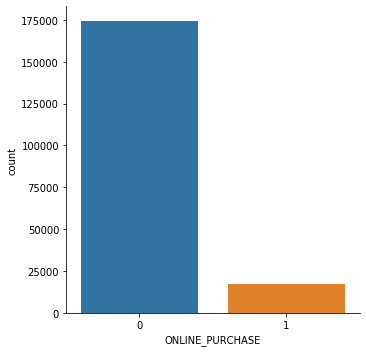

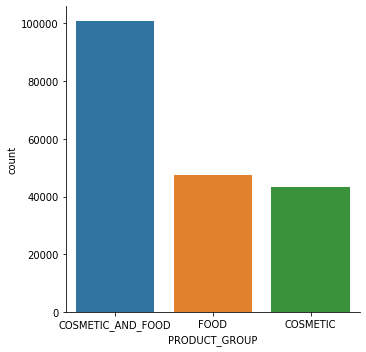

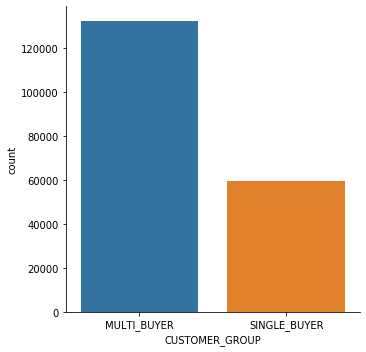

In [10]:
for col in extra_customer_cols:
    sns.catplot(x=col,
                kind='count',
                data=customers)

Now let's check and see if we have information in the documentation for all the columns found in AZDIAS

In [11]:
attribute_cols = attributes['Attribute'].unique()

In [12]:
columns_missing_desc = list(set(azdias_cols) - set(attribute_cols))

In [13]:
print(columns_missing_desc)

['KBA13_ANTG2', 'D19_VERSI_ONLINE_DATUM', 'KBA13_ANTG1', 'D19_BANKEN_REST', 'CJT_TYP_5', 'D19_TELKO_REST', 'D19_SONSTIGE', 'D19_BEKLEIDUNG_REST', 'D19_ENERGIE', 'D19_KOSMETIK', 'D19_WEIN_FEINKOST', 'LNR', 'D19_BANKEN_DIREKT', 'ANZ_KINDER', 'D19_LOTTO', 'UNGLEICHENN_FLAG', 'D19_VERSI_DATUM', 'D19_RATGEBER', 'D19_BUCH_CD', 'RT_SCHNAEPPCHEN', 'D19_BEKLEIDUNG_GEH', 'KBA13_BAUMAX', 'ALTER_KIND1', 'VHN', 'D19_LEBENSMITTEL', 'D19_VOLLSORTIMENT', 'CJT_TYP_4', 'MOBI_RASTER', 'UMFELD_ALT', 'D19_NAHRUNGSERGAENZUNG', 'KBA13_KMH_210', 'EINGEFUEGT_AM', 'AKT_DAT_KL', 'KBA13_GBZ', 'UMFELD_JUNG', 'ALTER_KIND2', 'D19_BILDUNG', 'D19_DIGIT_SERV', 'D19_KINDERARTIKEL', 'EXTSEL992', 'D19_TECHNIK', 'RT_KEIN_ANREIZ', 'D19_TELKO_MOBILE', 'KBA13_CCM_1401_2500', 'D19_FREIZEIT', 'VK_DHT4A', 'VHA', 'KK_KUNDENTYP', 'D19_HAUS_DEKO', 'D19_SCHUHE', 'D19_REISEN', 'ALTER_KIND3', 'STRUKTURTYP', 'EINGEZOGENAM_HH_JAHR', 'GEMEINDETYP', 'ALTER_KIND4', 'KBA13_HHZ', 'D19_SAMMELARTIKEL', 'DSL_FLAG', 'D19_GARTEN', 'RT_UEBERGROESS

We clearly do not, and this could pose a problem for identifying the correct missing values. Other than the columns that we'll deal with later that are of type **object** we can discard the other unknown columns for the purpose of this analysis.

## Fixing columns 18 and 19, feature engineering on object columns, and replacing unknown values with NaN

### Columns 18 and 19

Three tasks should be addressed before proceeding any further with data processing. The first is that there was error that was returned when loading the CSVs that columns 18 and 19 had mixed data types found. We'll need to parse through these to determine the issue

In [14]:
error_cols = azdias_cols[18:20]

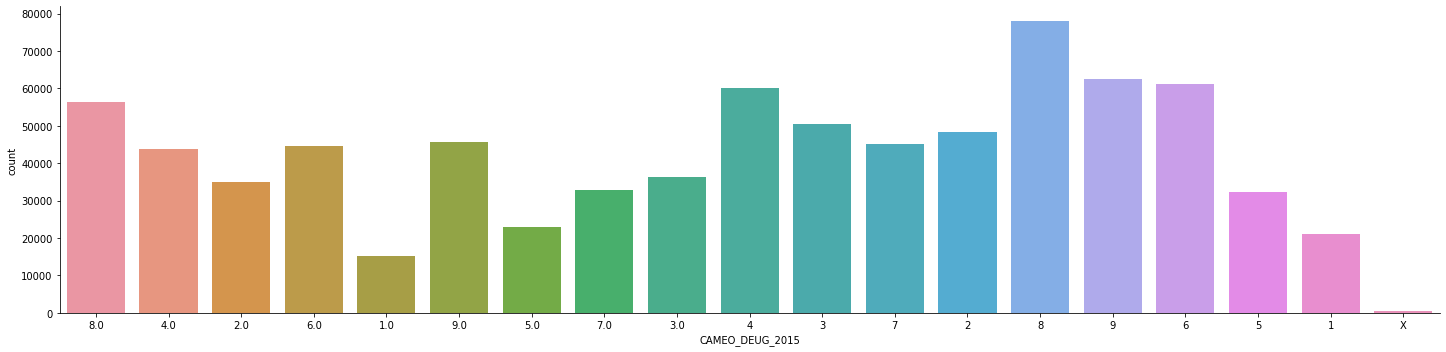

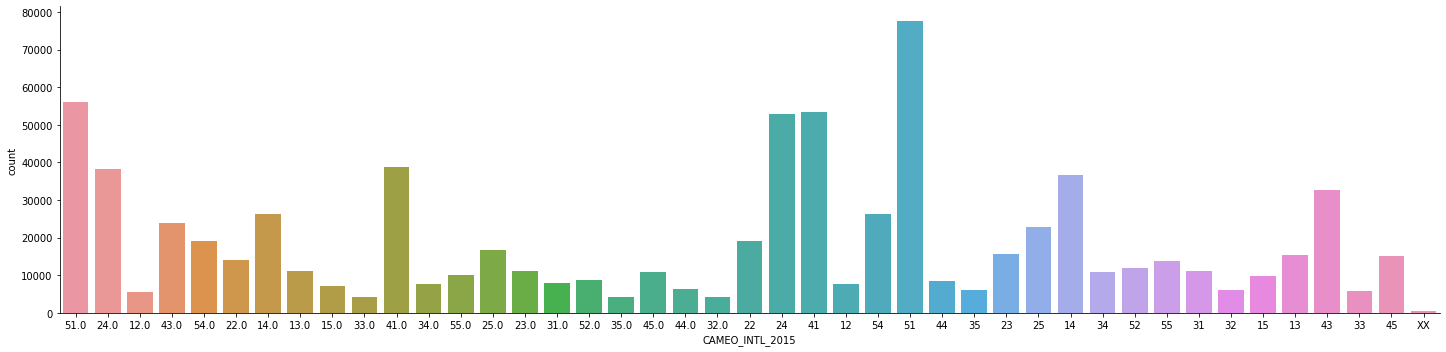

In [15]:
for col in error_cols:
    sns.catplot(kind='count',
                data=azdias,
                x=col,
                aspect=4)

Based on the two histograms above, it looks like there is a mix between float and integer datatypes, as well as what looks to be erroneous data in the form of 'X' and 'XX'. We'll replace these with np.nan, and convert the rest of the data to floats.

In [16]:
def clean_columns_18_19(df):
    columns = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    df[columns] = df.loc[:, columns].replace(['X', 'XX'], np.nan)
    df[columns] = df.loc[:, columns].astype(float)
    return df

In [17]:
azdias = clean_columns_18_19(azdias)

Checking the same plot as above now shows consistent data for columns 18 and 19

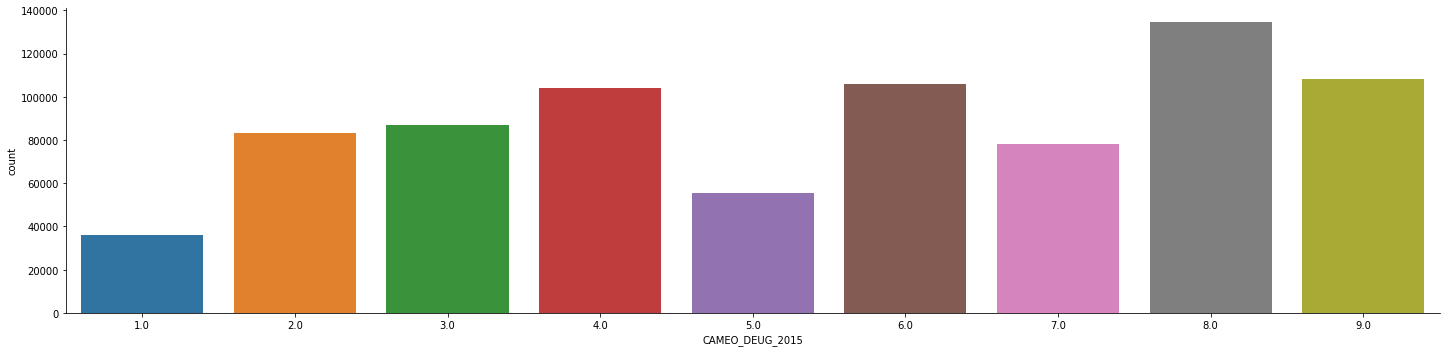

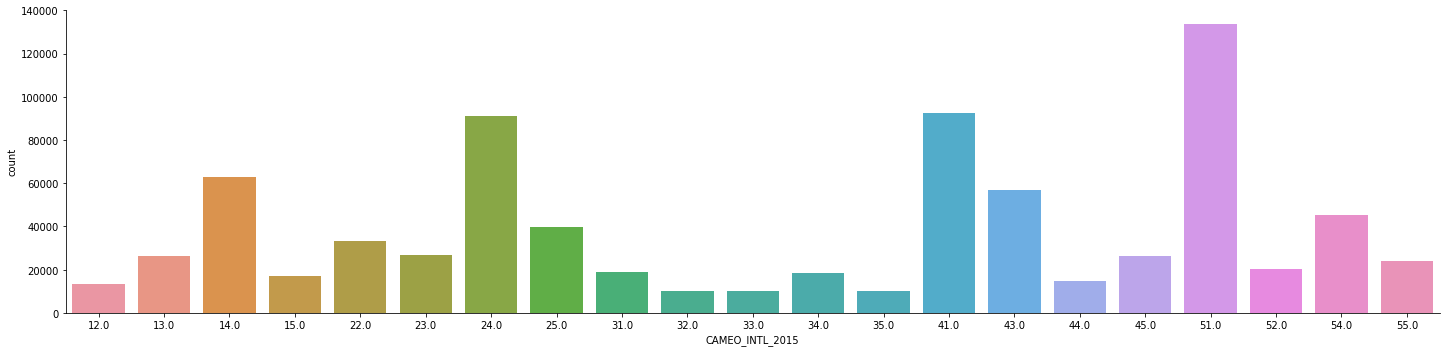

In [18]:
for col in error_cols:
    sns.catplot(kind='count',
                data=azdias,
                x=col,
                aspect=4)

## Feature engineering object columns

Datatype of **object** in pandas dataframes is the most generic type of column. We'll want to create either numerical features out of these, or one-hot encode them for the customer segmentation or supervised learning to work as intended

In [19]:
object_data = azdias.select_dtypes(include='object')
object_data_cols = object_data.columns
object_data

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...
891216,7A,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,D19_UNBEKANNT,1992-02-12 00:00:00,W


First, let's see what these columns represent from the provided attribute information

In [20]:
information[information['Attribute'].isin(object_data_cols)]

,Information level,Attribute,Description,Additional notes
83,NaN,OST_WEST_KZ,flag indicating the former GDR/FRG,NaN
86,NaN,CAMEO_DEU_2015,CAMEO_4.0: specific group,NaN


In [21]:
attributes[attributes['Attribute'].isin(object_data_cols)]

,Attribute,Description,Value,Meaning
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
62,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1B,Wealthy Best Ager
63,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1C,Successful Songwriter
64,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1D,Old Nobility
65,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1E,City Nobility
66,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2A,Cottage Chic
67,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2B,Noble Jogger
68,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2C,Established gourmet
69,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2D,Fine Management
70,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,3A,Career & Family


In [22]:
attributes[attributes['Attribute'] == 'CAMEO_DEU_2015'].iloc[1].Description

'CAMEO classification 2015 - detailled classification'

In [23]:
print(f"There are {azdias['CAMEO_DEU_2015'].nunique()} unique values for CAMEO_DEU_2015")
print(f"There are {azdias['D19_LETZTER_KAUF_BRANCHE'].nunique()} unique values for D19_LETZTER_KAUF_BRANCHE")
print(f"There are {azdias['OST_WEST_KZ'].nunique()} unique values for OST_WEST_KZ")

There are 45 unique values for CAMEO_DEU_2015
There are 35 unique values for D19_LETZTER_KAUF_BRANCHE
There are 2 unique values for OST_WEST_KZ


In [24]:
# inspect for missing values in the first two columns listed
azdias[['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']].isna().sum() / azdias.shape[0]

CAMEO_DEU_2015              0.111060
D19_LETZTER_KAUF_BRANCHE    0.288495
dtype: float64

Only two of the four clumns with object data type have an explanation in the documentation provided. Of those two, I can see that OST_WEST_KZ is easy to code into a binary indicator of whether or not the custmer was in the West or not with a simple dictionary translation.

Since we have sufficiently large training data, I won't worry about over complicating the feature engineering for CAMEO_DEU_2015, which is also found in the documentation, and will simply one-hot encode this into a series of binary indicator bits.

One of the two features not found in the documentation appears to translate to "inserted" and I will take that as the timestamp when the data was added to the customer dataset. This is not of particular use to our tasks at hand, and will be dropped.

The second feature that is not in the documentation, D19_LETZTER_KAUF_BRANCHE, translates to the industry of last purchase. This could serve as useful information, and so even though we do not have supporting documentation, we will keep this and one-hot encode it as well.

Adding both one-hot encoded features adds a total of 76 features to our dataset, with removing the original two. Since there are some missing values in both columns, we won't be using the drop_first parameter from the pd.get_dummies function, as that would then imply membership to the first category when the data is in act missing


In [25]:
def ost_west_encoder(df):
    encoder = {
        'O': 0,
        'W': 1
    }
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(encoder)
    return df

In [26]:
def one_hot_enc(df, col):
    dummies = pd.get_dummies(df[col])
    df_list = [df.drop(col, axis=1), dummies]
    return pd.concat(df_list, axis=1)

## Replacing missing values with np.NaN

There are known unknowns in the dataset, that are coded with non-null values. We can decode these with the documentation, and replace them with a generic np.nan value, so that we can both make decisions about the completeness of either an observation or a feature entirely, and also then to impute value for features we want to keep so that we can use them in future machine learning algorithms

In [27]:
attributes.loc[attributes['Meaning'] == 'unknown'].head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown


There are some cases where there are two values that translate to unknown. This can be from a changing data collection over time, or through combining data sets. The first step in this process will be to lookup the unknown values for a specific column.

In [28]:
def lookup_unknown_val(col, attributes):
    """
    This function returns a list of integer values that 
    correspond to unknown values in the data based on the column
    """
    try:
        mask = (attributes['Attribute'] == col) & (attributes['Meaning'].str.startswith('unknown'))
        unknown_val = attributes.loc[mask, 'Value']
        split_string = unknown_val.astype(str).str.cat(sep=',')

        return [int(x) for x in split_string.split(',')]

    except ValueError:
        return []

In [29]:
print(f"The unknown values for AGER_TYP are {lookup_unknown_val('AGER_TYP', attributes)}")
print(f"The unknown values for ALTER_HH are {lookup_unknown_val('ALTER_HH', attributes)}")
print(f"The unknown values for ALTERSKATEGORIE_GROB are {lookup_unknown_val('ALTERSKATEGORIE_GROB', attributes)}'")
print(f"The unknown values for D19_TELKO_ANZ_24 are {lookup_unknown_val('D19_TELKO_ANZ_24', attributes)}'")
print(f"The unknown values for HEALTH_TYP are {lookup_unknown_val('HEALTH_TYP', attributes)}'")

The unknown values for AGER_TYP are [-1]
The unknown values for ALTER_HH are [0]
The unknown values for ALTERSKATEGORIE_GROB are [-1, 0]'
The unknown values for D19_TELKO_ANZ_24 are []'
The unknown values for HEALTH_TYP are [-1]'


Now we can try out the function on some of our data. Here is a before view on HEALTH_TYP

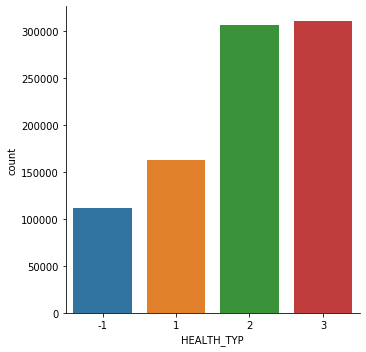

In [30]:
g = sns.catplot(x='HEALTH_TYP',
                kind='count',
                data=azdias)

And then we can use our function to clean up the data look at the data after

In [31]:
azdias['HEALTH_TYP'] = azdias['HEALTH_TYP'].replace(lookup_unknown_val('HEALTH_TYP', attributes), np.nan)

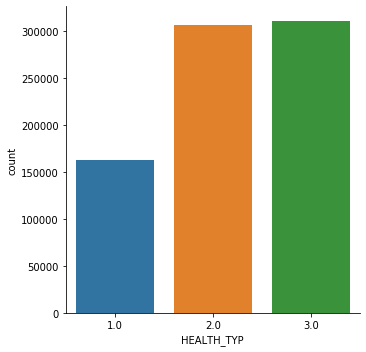

In [32]:
g = sns.catplot(x='HEALTH_TYP',
                kind='count',
                data=azdias)

As expected, the -1 value is gone, and replace by a np.nan, that is not plotted. Now we can loop over all the columns in the dataframe and apply the same.

In [33]:
def replace_unknowns_with_nan(df, attributes):
    for col in df.columns:
        df[col] = df[col].replace(lookup_unknown_val(col, attributes), np.nan)
    return df

In [34]:
azdias = replace_unknowns_with_nan(azdias, attributes)

Next we'll come back to removing columns that we don't have enough information about. We can always return and try to add these back in when time permits, but for this analysis, we'll remove them.

Remember, there are three columns that we've decided to keep from before that may be in that list of values, so we're going to want to make sure they are removed from the set

In [35]:
modified_object_data_cols = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'] # we don't want the timestamp column

columns_to_delete = list(set(columns_missing_desc) - set(modified_object_data_cols))
columns_to_delete

['KBA13_ANTG2',
 'D19_SCHUHE',
 'D19_REISEN',
 'D19_VERSI_ONLINE_DATUM',
 'ALTER_KIND3',
 'KBA13_ANTG1',
 'D19_BANKEN_REST',
 'STRUKTURTYP',
 'CJT_TYP_5',
 'D19_TELKO_REST',
 'D19_SONSTIGE',
 'EINGEZOGENAM_HH_JAHR',
 'D19_BEKLEIDUNG_REST',
 'D19_ENERGIE',
 'GEMEINDETYP',
 'D19_KOSMETIK',
 'D19_WEIN_FEINKOST',
 'ALTER_KIND4',
 'KBA13_HHZ',
 'LNR',
 'D19_SAMMELARTIKEL',
 'D19_BANKEN_DIREKT',
 'ANZ_KINDER',
 'D19_LOTTO',
 'DSL_FLAG',
 'UNGLEICHENN_FLAG',
 'D19_VERSI_DATUM',
 'D19_RATGEBER',
 'D19_GARTEN',
 'D19_BUCH_CD',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'D19_BEKLEIDUNG_GEH',
 'KBA13_BAUMAX',
 'D19_BANKEN_LOKAL',
 'ALTER_KIND1',
 'D19_VERSI_ONLINE_QUOTE_12',
 'VHN',
 'D19_LEBENSMITTEL',
 'VK_ZG11',
 'D19_HANDWERK',
 'VERDICHTUNGSRAUM',
 'KOMBIALTER',
 'KONSUMZELLE',
 'D19_VOLLSORTIMENT',
 'CJT_TYP_4',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_BIO_OEKO',
 'MOBI_RASTER',
 'UMFELD_ALT',
 'KBA13_ANTG4',
 'CJT_KATALOGNUTZER',
 'D19_NAHRUNGSERGAENZUNG',
 'CJT_TYP_2',
 'KBA13_KMH_210

In [36]:
def drop_columns(df, cols):
    return df.drop(cols, axis=1)

In [37]:
azdias = drop_columns(azdias, columns_to_delete)

## Drop columns with high missing value content

Features that are missing too many values are not valuable in this process, so we'll want to identify and remove those from our data. First, let's explore the data to see what the distribution of missing value proportions between features are

In [38]:
missing_value_percentages = pd.DataFrame(azdias.isnull().sum() / azdias.shape[0], columns=['Missing Val Prop'])

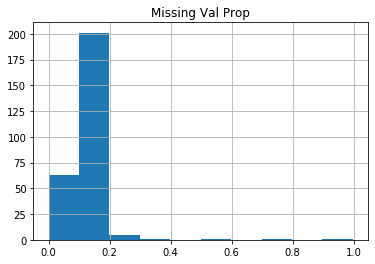

In [39]:
_ = missing_value_percentages.hist()

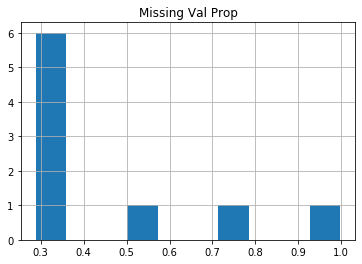

In [40]:
_ = missing_value_percentages[missing_value_percentages['Missing Val Prop'] > .2].hist()

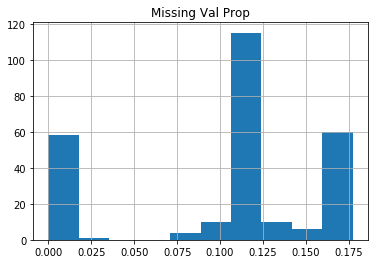

In [41]:
_ = missing_value_percentages[missing_value_percentages['Missing Val Prop'] < .2].hist()

It seems that if we move too far below a 20% threshold, we'll start remove many features. A threshold of 20% seems to be a good cut off to remove, however we know that D19_LETZTER_KAUF_BRANCHE has 29% missing values from our previous exploration of object data, and have decided to keep it since it is one of just a few that were ofobject type. Let's first one-hot encode those features before then remove these missing values. While we're at it, we'll also encode the final categorical feature that needed tranformation to a binary indicator.

In [42]:
azdias = one_hot_enc(azdias, ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'])
azdias = ost_west_encoder(azdias)

In [43]:
azdias

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORI

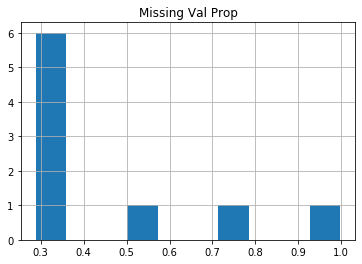

In [44]:
_ = missing_value_percentages[missing_value_percentages['Missing Val Prop'] > .2].hist()

In [45]:
def missing_percentages(df):
    missing = pd.DataFrame(df.isna().sum() / df.shape[0]).reset_index()
    missing.columns = ['Attribute', 'Missing']
    return missing

In [46]:
def remove_features_by_missingness(df, threshold=1):
    missing = missing_percentages(df)
    cols = missing.loc[missing['Missing'] > threshold, 'Attribute'].tolist()
    if len(cols) > 0:
        df = df.drop(cols, axis=1)
    return df

In [47]:
azdias = remove_features_by_missingness(azdias, .2)

In [49]:
def map_male(df):
    encoder = {
        2: 0,
        1: 1
    }
    df['ANREDE_KZ'] = df['ANREDE_KZ'].map(encoder).astype('uint8')
    return df

In [50]:
azdias = map_male(azdias)

In [53]:
azdias['ANREDE_KZ'].value_counts()

0    465305
1    425916
Name: ANREDE_KZ, dtype: int64


Now, I'll create two lists of columns: one to be scaled, and the binary indicator columns that I don't want scaled

In [54]:
def return_scaled_columns_list(df):
    return df.select_dtypes(exclude='uint8').columns, df.select_dtypes(include='uint8').columns

In [55]:
scaled_col_list, non_scaled_col_list = return_scaled_columns_list(azdias)

In [57]:
scaled_df = azdias[scaled_col_list]

In [56]:
from sklearn.preprocessing import StandardScaler

In [61]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(scaled_df)

In [71]:
scaled_df = pd.DataFrame(scaled_array, columns=scaled_col_list)

In [72]:
from sklearn.impute import SimpleImputer

In [74]:
imputer = SimpleImputer(strategy='median')

In [75]:
azdias_scaled_imputed = pd.DataFrame(imputer.fit_transform(scaled_df), columns = scaled_col_list)

In [76]:
azdias_clean_scaled = pd.concat([azdias_scaled_imputed, azdias[non_scaled_col_list]], axis=1)

In [82]:
sum(azdias_clean_scaled.isna().sum().tolist())

0

## Creating a pipeline for the data

Now that the exploration is done, I'll create a pipeline so that data can flow through without all of the noise of exploratory data analysis

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.